# 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#df = pd.DataFrame(boston.data, columns=boston.feature_names)
#df['target'] = boston.target

In [3]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Property Tax rate in the area|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. Regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

### Adding more readable column names

In [6]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [7]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [9]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


#### Distribution of values

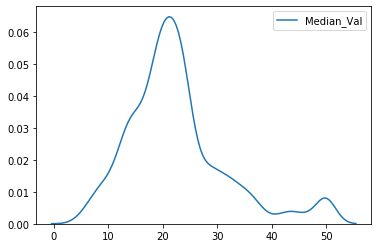

In [11]:
sns.kdeplot(df['Median_Val'])

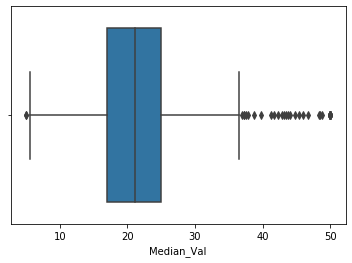

In [12]:
sns.boxplot(df['Median_Val'])

In [13]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


There are lots of outliers in the upper range of values

### Note look at this article 
https://www.ritchieng.com/machine-learning-project-boston-home-prices/

Good examples of data exoplorations and statistics on pricing 
And linear regression later on.

Creating a corrolation matrix to see if there is any relationship betweek the variables.

In [14]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


In [15]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

The average number of Rooms per House (0.7) and the % of People of Lower Status (-0.74) are the mostly strongly corrolated with the Median Value of houses

Also, worth noting the high corrolation between NOX and industrialisation (0.76) , Tax and Access to Highways (0.91)

### Corrolation and Sensitivity to different variables

1. Benefit of less NOX drops when DIS and RAD are removed. This is because the advantages of greater accessability cancel out the disadvantages of less clean air. 
2. The affect of higher NOX levels can easily be attributed to a higher proportion of lower status households. 
3. In general there is a high degree of heteroscedasticity. As X increases there is a larger variance in Y. 

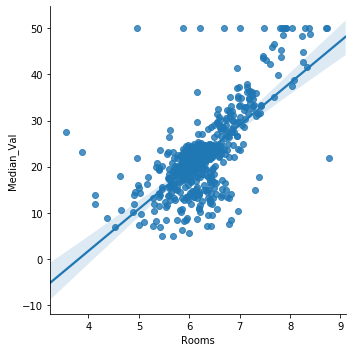

In [16]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

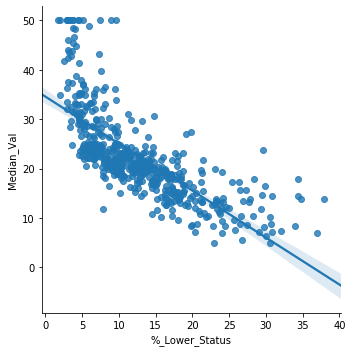

In [17]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

Looking at 2 next most closely corrolated attributes: Crime rate and Pupil teacher ratio shows there is a far less obvious relationship.

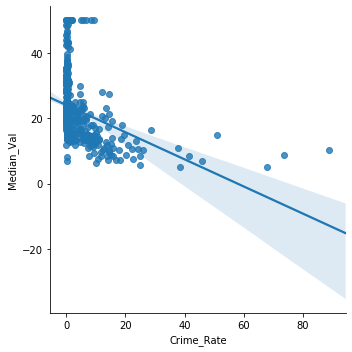

In [18]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="Crime_Rate", y="Median_Val", data=df)

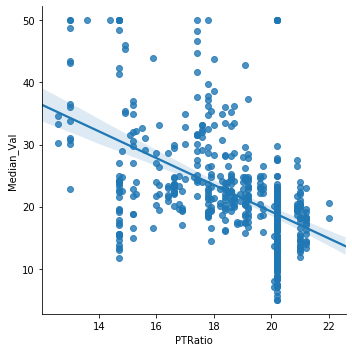

In [19]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below..

In [20]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [21]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

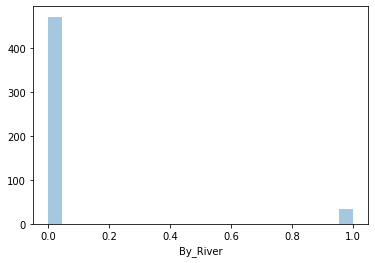

In [22]:
sns.distplot(df['By_River'], kde=False)

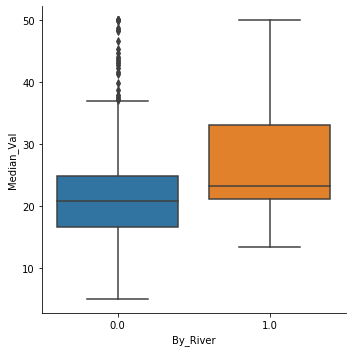

In [23]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

As we can see from the above counts and histogram, there are significantly more areas in our dataset that are located away from the Charles rive (471) vs next to the Charles River (35). There are also a significant number of outliers in the Median Value of houses in areas that are away from the river.

### Discuss issues with unequal sample sizes

Unequal sample sizes are a common issue that can lead to:
* Unequal variances between samples, which affects the assumption of equal variances in ANOVA Tests. 
* A general loss of power as equal size groups maxamize statistical power. This means it less likely the test will detect and effect if there is an effect to be detected.
* Issues with confounding variables.

However, while we need to be mindful of this it does not invalidate the results of an ANOVA test. 

In [24]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [25]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

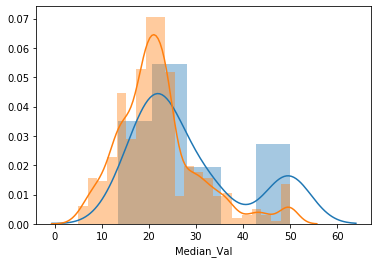

In [26]:
ax = sns.distplot(next_to_river['Median_Val'])
ax = sns.distplot(away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

### T-test

Before we can apply a T-Test, it first necessary to ensure that our datasets meet the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

### Removing Outliers

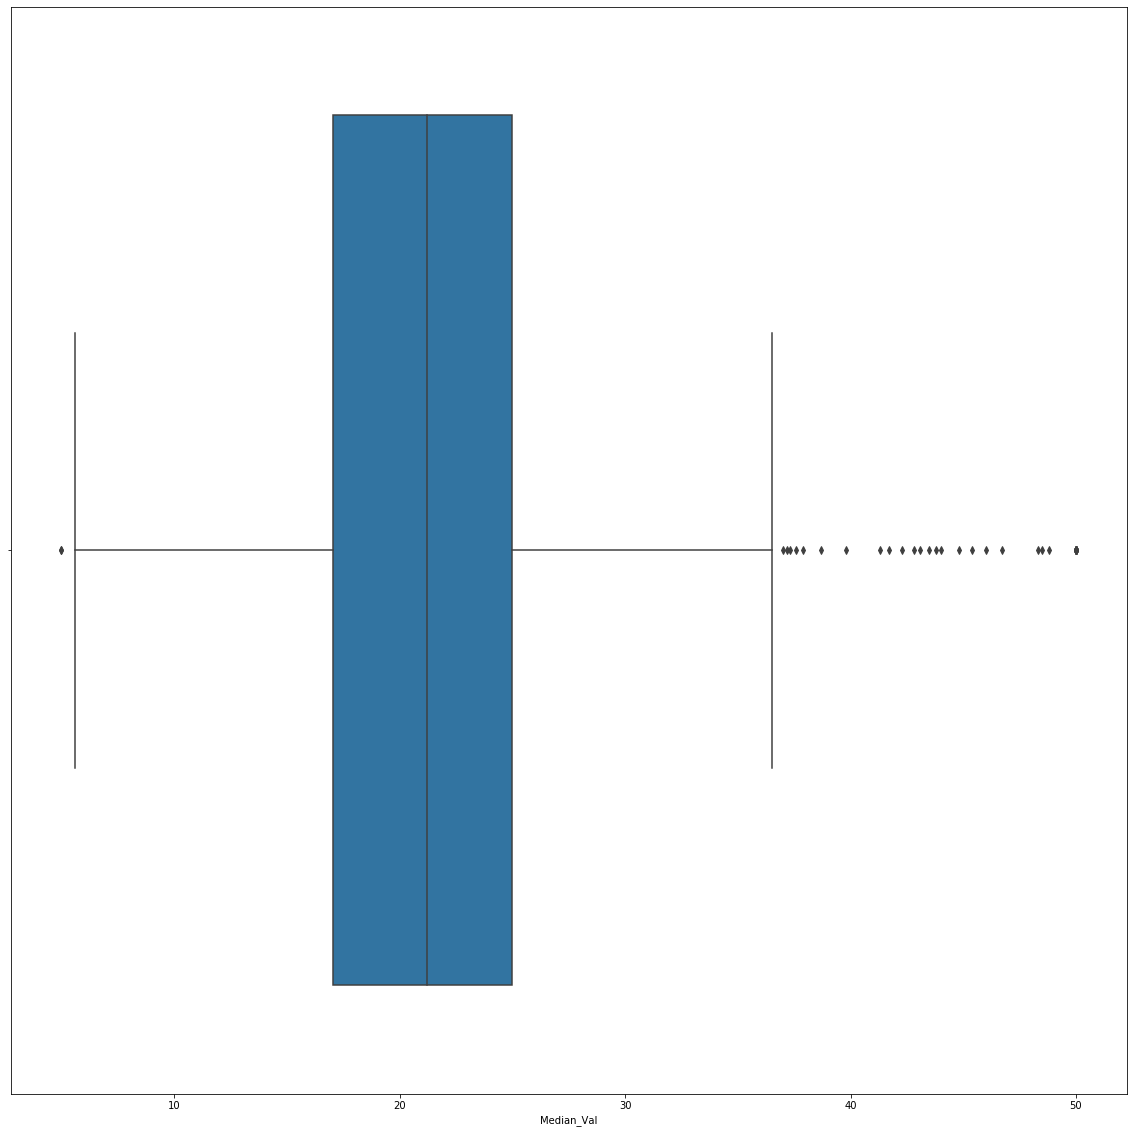

In [27]:
sns.boxplot(df['Median_Val'])

As we can see from the boxplot that we generated earlier there are a significant number of outliers in the target variable ("Median_Val"). There are also 16 areas where the median value of houses is $50,000. This indicates  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers we need to assign a threshold for the Median Value, above or below which we will consider the data point to be an outlier. The most obvious way of this is to follow the same method as the box-plot an remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [28]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [29]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [30]:
IQR = Q3 - Q1
IQR

7.975000000000001

Now that the interquartile range has been calculated we can find the upper and lower "whisker" values for the box plot which will acts as our thresholds.

In [31]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [32]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [33]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There are two data points below the lower threshold.

In [34]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [35]:
above["Median_Val"].count()

38

There are 38 datapoints that are higher that the upper threshold. We can create a dataset called "no_outliers" that does not contain any outliers by removing both these groups.

In [36]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


We can then compare what our two populations look like with the outliers removed.

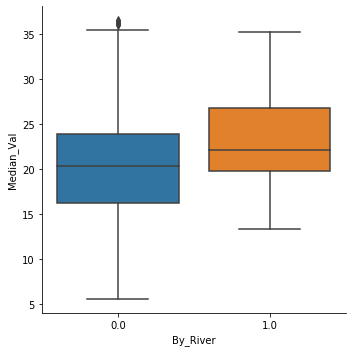

In [37]:

sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

### The dependant varibale needs to be approxmately normally distributed in each group.

In order to test this I created two new groups from the "no_outliers" dataset.

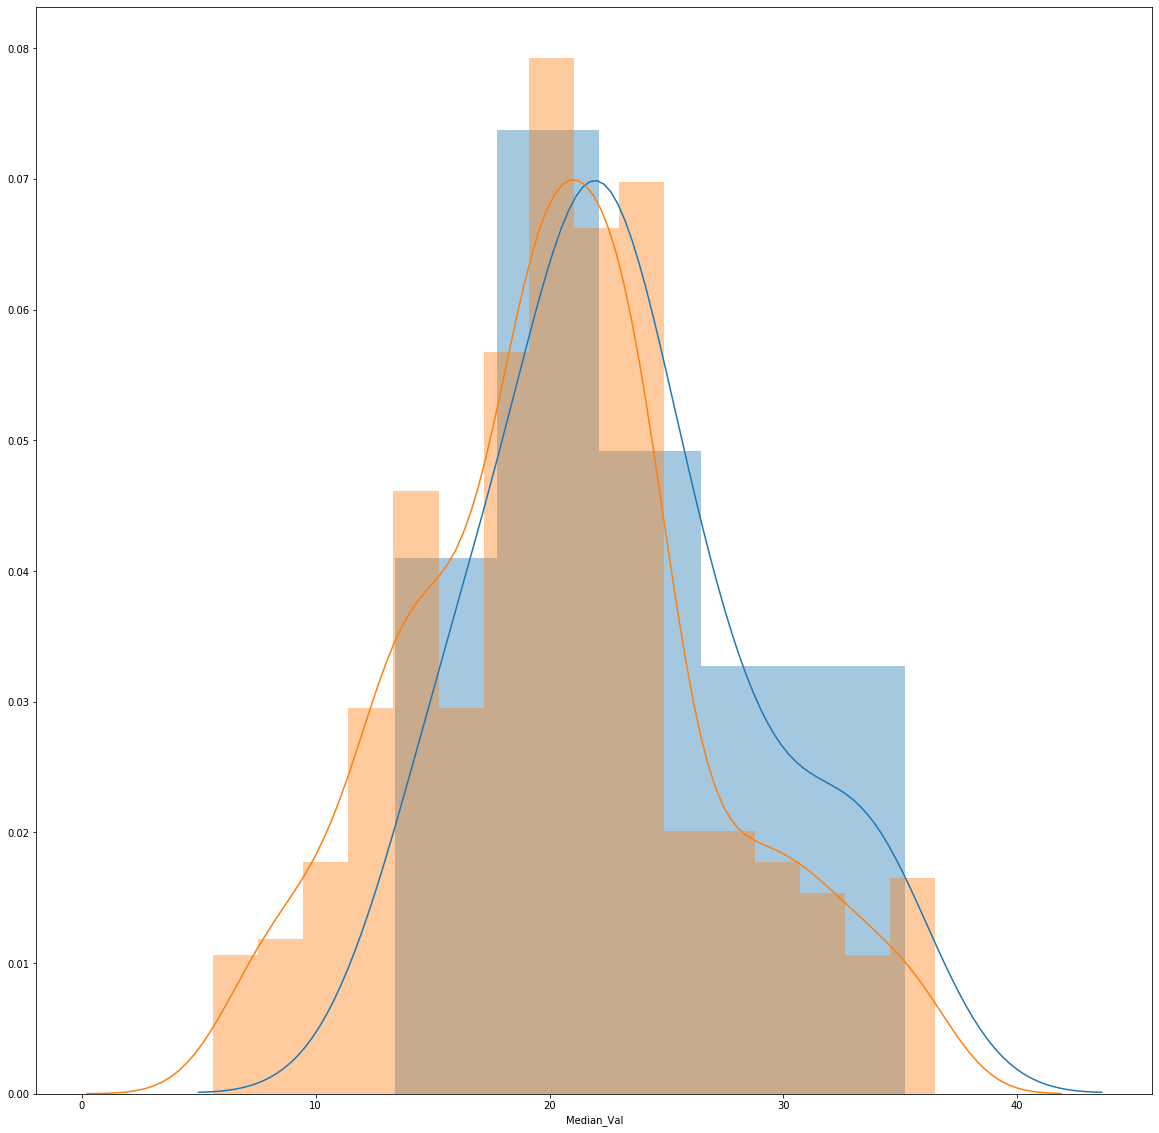

In [38]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" datasets it can be observed that both are much closer to appearing to be normally distributed. However, we will need to test for this using Scipys "normaltest" function.

In [39]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). We can therefore say with a good degree of certainty that the data is normally distributed.
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid ttest we need to check if both samples have similar variances. Levenes test can be used to do this it. It tests the null hypothosis that variances are equal. 

In [40]:
# 
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The Pvalue is greater than the threshold of 0.05 so we can say that there is no signifcant difference in the variances of both groups.

In [41]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [42]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


### Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have removed them.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [43]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current study was to test if there is a significant difference in the Median_Value between the house prices in areas by or not by the Charles River in Boston.

In [44]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [45]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference > 0 p value =,0.9819
5,Difference < 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test show a P value of 0.0362. This is lower than the 0.05 giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

We can thereforce conclude that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predictions


Add section discussiong the variables that were selected and why. 

What is the relationship between them all.

ANOVA Test?

## 4.1 Pre-Processing

Preprocessing is an integral step in Machine Learning. Quality of the data must be as good as possible before feeding into the model.

There are a number of different steps we can take to preprocesss the data and ensure the quality of the data:

1. Deal with any Null values
2. Deal with Categorical Variables
3. Standardise the Data


### 4.1.1 Null Values

First we will check to ensure if our cleansed dataset contains any Null values. If there are Null values, the row containing the value will be need to be removed of the value will need to be replaced.

In [46]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

As we can see, no of the columns contain Null values. So we can move on.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located by or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore we dont have to do any encoding or processing of this variable.

In [47]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise the Data

In standardisation we transform all values such that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, if we look at the below we can see that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [48]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before we scale the data it needs to be split into the independent and dependent variables for the model.

It also a good idea to shuffle the data before going any further. 

In [49]:
no_outliers = shuffle(no_outliers)

In [50]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

The data then needs to be split into the testing and training sets. For this project we will use a 80:20 train:test split. 

We can use Sklearns model selection tool for this.

In [51]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [52]:
x_train.iloc[0]

Crime_Rate          0.05644
%_Large_Plots      40.00000
%_Indus             6.41000
By_River            1.00000
NOX                 0.44700
Rooms               6.75800
%_Pre_1940         32.90000
Dist_to_Jobs        4.07760
Highway_Access      4.00000
Tax               254.00000
PTRatio            17.60000
Blks_per_1000     396.90000
%_Lower_Status      3.53000
Name: 274, dtype: float64

Once the data is split into testing and training sets it can be scaled.


In [53]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [54]:
x_train.iloc[0]

Crime_Rate       -0.460199
%_Large_Plots     1.274503
%_Indus          -0.759956
By_River          4.088311
NOX              -0.944378
Rooms             1.033198
%_Pre_1940       -1.304786
Dist_to_Jobs      0.104251
Highway_Access   -0.689026
Tax              -0.972396
PTRatio          -0.508171
Blks_per_1000     0.440036
%_Lower_Status   -1.411860
Name: 0, dtype: float64

##  4.2 Baseline prediction test

At this stage I performed an inital test of the model to act as a performance baseline. I tuned this model further following this test.

In [114]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [115]:
# why am I using these epochs and batch sizes
m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 0s 442us/step - loss: 412.6249
Epoch 2/100
372/372 [==============================] - 0s 175us/step - loss: 377.0642
Epoch 3/100
372/372 [==============================] - 0s 162us/step - loss: 332.8279
Epoch 4/100
372/372 [==============================] - 0s 179us/step - loss: 279.5712
Epoch 5/100
372/372 [==============================] - 0s 170us/step - loss: 222.2137
Epoch 6/100
372/372 [==============================] - 0s 173us/step - loss: 167.1551
Epoch 7/100
372/372 [==============================] - 0s 187us/step - loss: 119.9915
Epoch 8/100
372/372 [==============================] - 0s 185us/step - loss: 84.8411
Epoch 9/100
372/372 [==============================] - 0s 173us/step - loss: 62.6597
Epoch 10/100
372/372 [==============================] - 0s 181us/step - loss: 48.7776
Epoch 11/100
372/372 [==============================] - 0s 177us/step - loss: 39.6743
Epoch 12/100
372/372 [==============================] - 

Epoch 97/100
372/372 [==============================] - 0s 164us/step - loss: 6.2690
Epoch 98/100
372/372 [==============================] - 0s 159us/step - loss: 6.2242
Epoch 99/100
372/372 [==============================] - 0s 164us/step - loss: 6.2150
Epoch 100/100
372/372 [==============================] - 0s 145us/step - loss: 6.1842


In [116]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[19.16846 , 11.757953, 32.302532, 24.89352 , 28.55768 , 28.518253,
        20.888899, 16.539772, 29.086243, 31.457363, 20.883184, 19.391727,
        16.670252, 24.063646,  8.832976, 18.067581, 31.028067, 19.265863,
        11.263635, 15.384428, 14.021076, 23.794981, 17.0425  , 23.323257,
        22.925745, 18.992285, 25.823729, 29.800741, 30.726555,  9.185813,
        34.229828, 18.591381, 19.596407, 15.602027, 19.459112, 13.68699 ,
        34.45064 , 23.396685, 21.69537 , 16.312561, 24.723011, 26.435717,
        13.300701, 21.667494, 12.41764 , 20.246035, 15.41139 , 17.51353 ,
        17.901026, 17.566193, 29.707102, 13.538848, 31.484924, 23.878857,
        23.954388, 13.817871, 20.36003 , 12.781504, 12.624628, 28.678936,
        22.456358, 21.805487, 10.653869,  8.903043, 22.796896, 28.123384,
        13.920076, 25.95573 , 18.687431, 21.598442, 11.408713, 21.971176,
        19.238813, 26.319962, 31.66712 , 28.108963, 12.859716, 29.638388,
        25.078268, 24.065622, 29.21032

In [117]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([18.7, 13.2, 34.9, 22.9, 26.6, 28.4, 24.5, 18.4, 29. , 28.7, 11.9,
       19.6, 18.9, 22.6,  8.8, 13.6, 26.7, 23. , 27.5,  7. , 14.5, 27.5,
       18.1, 22.6, 22.9, 22.9, 29.8, 29. , 33.1, 11.8, 33.8, 21.7, 20.6,
       16.1, 19.2, 13. , 33.2, 22.6, 21.4, 14.2, 22.8, 25.3, 13.5, 21.7,
       10.9, 21. , 11.9, 19.4, 18.9, 21.7, 31.6,  8.1, 32.7, 23.3, 23. ,
       16.5, 16.6, 13.8, 14.1, 30.8, 22.4, 25. , 14.9, 13.4, 21.5, 28.4,
       15.4, 23.4, 21.4, 24.3,  9.6, 16.5, 17.1, 23.9, 36.2, 26.6, 13.6,
       29.9, 24.8, 25. , 36.4, 22.5, 35.1, 36.1, 17.5, 22.2, 19.1, 23.7,
       17.3, 19.4, 17.2, 21.7, 23.4, 19.7], dtype=float32)

In [118]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,19.168461,18.700001,2.443911
1,11.757953,13.200000,12.264441
2,32.302532,34.900002,8.041070
3,24.893520,22.900000,8.008191
4,28.557680,26.600000,6.855178
5,28.518253,28.400000,0.414660
6,20.888899,24.500000,17.287178
7,16.539772,18.400000,11.246996
8,29.086243,29.000000,0.296507
9,31.457363,28.700001,8.765396


In [119]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

12.829821

In [120]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 594us/step


10.620617967970828

## 4.3 Factor to Consider When Creating a Model

Before going any further it is worth outlining my reasoning for selecting the options that I did when creating this Baseline model and considerations for improving the model in later iterations.

#### Model Selection

I used the Sequential Model. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary what we are trying to achieve.

#### Density

This is the layer type. In this type all node/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). 

#### Number of Layers

For the baseline we have added 1 input later and 1 output layer. This is the absolute minimum number we can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models , having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I will introduce additional layers in later iterations of the model.

#### Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this case we have 13 input variables and required 1 output. This is what has been entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively reducing accuracy. 

There are some rules of thumb such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

These fail to take account of size of the training dataset and other considerations [3]. 

We will expriment with different unit sizes in later iterations.



#### Activation Function

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This is obviously not suitable for this projects dataset, but there are several others that are worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scalled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers of activated by the ReLU function. 
* ReLu should only be used in hidden layers.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left at the default linear function. 




#### Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error" [6].

#### Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I do not think there would be much value in using other optimizers.

#### Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In our Baseline Model we have set the model to perform 100 epochs. We will try larger numbers of epochs in later iterations. 

#### Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 


## 4.4 Model Tuning - Round 1

I will now test updating the model based on some of the possible improvements discussed above

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I will not be changing:
1. Activation functions
2. Loss function
3. Optimizer
From my investigation, the options in the Baseline Model already seem to be the best fit for the dataset.

### 4.4.1 Batch Sizes

###### Test 1-  Increasing Batch Size to 32


In [126]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=32)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch1 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 390us/step - loss: 439.8721
Epoch 2/100
372/372 [==============================] - 0s 38us/step - loss: 433.4267
Epoch 3/100
372/372 [==============================] - 0s 46us/step - loss: 426.8657
Epoch 4/100
372/372 [==============================] - 0s 37us/step - loss: 420.2063
Epoch 5/100
372/372 [==============================] - 0s 35us/step - loss: 413.1044
Epoch 6/100
372/372 [==============================] - 0s 40us/step - loss: 405.6417
Epoch 7/100
372/372 [==============================] - 0s 46us/step - loss: 397.5727
Epoch 8/100
372/372 [==============================] - 0s 40us/step - loss: 388.6746
Epoch 9/100
372/372 [==============================] - 0s 38us/step - loss: 379.1843
Epoch 10/100
372/372 [==============================] - 0s 40us/step - loss: 369.0265
Epoch 11/100
372/372 [==============================] - 0s 48us/step - loss: 358.0465
Epoch 12/100
372/372 [==============================] - 0s 43u

372/372 [==============================] - 0s 37us/step - loss: 15.8172
Epoch 98/100
372/372 [==============================] - 0s 40us/step - loss: 15.6836
Epoch 99/100
372/372 [==============================] - 0s 35us/step - loss: 15.5355
Epoch 100/100
94/94 [==============================] - 0s 914us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [127]:
result_batch1

19.031254017606695

###### Test 2 - Batch Size to 16

In [128]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=16)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch2 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 426us/step - loss: 454.3355
Epoch 2/100
372/372 [==============================] - 0s 67us/step - loss: 444.7338
Epoch 3/100
372/372 [==============================] - 0s 72us/step - loss: 434.4143
Epoch 4/100
372/372 [==============================] - 0s 67us/step - loss: 422.5184
Epoch 5/100
372/372 [==============================] - 0s 75us/step - loss: 408.5786
Epoch 6/100
372/372 [==============================] - 0s 69us/step - loss: 392.3202
Epoch 7/100
372/372 [==============================] - 0s 70us/step - loss: 373.9649
Epoch 8/100
372/372 [==============================] - 0s 74us/step - loss: 353.6464
Epoch 9/100
372/372 [==============================] - 0s 75us/step - loss: 332.0267
Epoch 10/100
372/372 [==============================] - 0s 72us/step - loss: 309.2074
Epoch 11/100
372/372 [==============================] - 0s 64us/step - loss: 286.3084
Epoch 12/100
372/372 [==============================] - 0s 72u

c:\users\conor\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.179523). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


Epoch 47/100
372/372 [==============================] - 0s 70us/step - loss: 19.0065
Epoch 48/100
372/372 [==============================] - 0s 68us/step - loss: 18.5276
Epoch 49/100
372/372 [==============================] - 0s 64us/step - loss: 18.0849
Epoch 50/100
372/372 [==============================] - 0s 59us/step - loss: 17.7165
Epoch 51/100
372/372 [==============================] - 0s 59us/step - loss: 17.3622
Epoch 52/100
372/372 [==============================] - 0s 62us/step - loss: 17.0510
Epoch 53/100
372/372 [==============================] - 0s 64us/step - loss: 16.7430
Epoch 54/100
372/372 [==============================] - 0s 62us/step - loss: 16.4418
Epoch 55/100
372/372 [==============================] - 0s 72us/step - loss: 16.2052
Epoch 56/100
372/372 [==============================] - 0s 70us/step - loss: 15.9374
Epoch 57/100
372/372 [==============================] - 0s 72us/step - loss: 15.6857
Epoch 58/100
372/372 [==============================] - 0s 78us/s

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [129]:
result_batch2

17.59374853905211

###### Test 3 - Batch Size to 4

In [131]:
# Test 3
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=4)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch3 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 635us/step - loss: 464.0595
Epoch 2/100
372/372 [==============================] - 0s 232us/step - loss: 405.6088
Epoch 3/100
372/372 [==============================] - 0s 230us/step - loss: 343.0021
Epoch 4/100
372/372 [==============================] - 0s 271us/step - loss: 279.5960
Epoch 5/100
372/372 [==============================] - 0s 238us/step - loss: 223.5122
Epoch 6/100
372/372 [==============================] - 0s 225us/step - loss: 181.8622
Epoch 7/100
372/372 [==============================] - 0s 225us/step - loss: 154.5976
Epoch 8/100
372/372 [==============================] - 0s 208us/step - loss: 138.0548
Epoch 9/100
372/372 [==============================] - 0s 225us/step - loss: 126.8315
Epoch 10/100
372/372 [==============================] - 0s 232us/step - loss: 117.3693
Epoch 11/100
372/372 [==============================] - 0s 213us/step - loss: 106.2947
Epoch 12/100
372/372 [==============================

372/372 [==============================] - 0s 215us/step - loss: 5.9967
Epoch 97/100
372/372 [==============================] - 0s 206us/step - loss: 5.9937
Epoch 98/100
372/372 [==============================] - 0s 200us/step - loss: 5.9479
Epoch 99/100
372/372 [==============================] - 0s 210us/step - loss: 5.9513
Epoch 100/100
94/94 [==============================] - 0s 1ms/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [132]:
result_batch3

10.570916662824915

###### Test 4 - Batch Size to 2

In [133]:
# Test 4
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=2)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch4 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 877us/step - loss: 420.7861
Epoch 2/100
372/372 [==============================] - 0s 439us/step - loss: 328.9064
Epoch 3/100
372/372 [==============================] - 0s 464us/step - loss: 213.4769
Epoch 4/100
372/372 [==============================] - 0s 440us/step - loss: 117.2140
Epoch 5/100
372/372 [==============================] - 0s 435us/step - loss: 66.4045
Epoch 6/100
372/372 [==============================] - 0s 448us/step - loss: 43.7266
Epoch 7/100
372/372 [==============================] - 0s 443us/step - loss: 31.1349
Epoch 8/100
372/372 [==============================] - 0s 504us/step - loss: 23.5700
Epoch 9/100
372/372 [==============================] - 0s 526us/step - loss: 19.2237
Epoch 10/100
372/372 [==============================] - 0s 393us/step - loss: 16.7676
Epoch 11/100
372/372 [==============================] - 0s 443us/step - loss: 15.3971
Epoch 12/100
372/372 [==============================] - 0s 

372/372 [==============================] - 0s 431us/step - loss: 5.0718
Epoch 98/100
372/372 [==============================] - 0s 386us/step - loss: 5.0224
Epoch 99/100
372/372 [==============================] - 0s 386us/step - loss: 5.0365
Epoch 100/100
94/94 [==============================] - 0s 1ms/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [134]:
result_batch4

9.919639262747257

#### 4.4.1.1 Commentary

Batch size of 2 achieves the best results, although at slightly diminishing returns vs a batch size of 4.

### 4.4.2 Number of Epochs

###### Test 1 - 500 Epochs

In [139]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 992us/step - loss: 408.8369
Epoch 2/500
372/372 [==============================] - 0s 482us/step - loss: 293.8858
Epoch 3/500
372/372 [==============================] - 0s 508us/step - loss: 172.0675
Epoch 4/500
372/372 [==============================] - 0s 470us/step - loss: 90.5434
Epoch 5/500
372/372 [==============================] - 0s 507us/step - loss: 54.1125
Epoch 6/500
372/372 [==============================] - 0s 466us/step - loss: 38.5678
Epoch 7/500
372/372 [==============================] - 0s 516us/step - loss: 30.1438
Epoch 8/500
372/372 [==============================] - 0s 460us/step - loss: 25.0828
Epoch 9/500
372/372 [==============================] - 0s 518us/step - loss: 21.8608
Epoch 10/500
372/372 [==============================] - 0s 469us/step - loss: 19.7715
Epoch 11/500
372/372 [==============================] - 0s 505us/step - loss: 18.2606
Epoch 12/500
372/372 [==============================] - 0s 4

Epoch 97/500
372/372 [==============================] - 0s 424us/step - loss: 5.0378
Epoch 98/500
372/372 [==============================] - 0s 421us/step - loss: 4.9734
Epoch 99/500
372/372 [==============================] - 0s 425us/step - loss: 5.0093
Epoch 100/500
372/372 [==============================] - 0s 421us/step - loss: 4.9673
Epoch 101/500
372/372 [==============================] - 0s 427us/step - loss: 4.9452
Epoch 102/500
372/372 [==============================] - 0s 403us/step - loss: 4.9429
Epoch 103/500
372/372 [==============================] - 0s 432us/step - loss: 4.9459
Epoch 104/500
372/372 [==============================] - 0s 420us/step - loss: 4.9428
Epoch 105/500
372/372 [==============================] - 0s 424us/step - loss: 4.9047
Epoch 106/500
372/372 [==============================] - 0s 432us/step - loss: 4.9102
Epoch 107/500
372/372 [==============================] - 0s 432us/step - loss: 4.8939
Epoch 108/500
372/372 [==============================] - 

372/372 [==============================] - 0s 441us/step - loss: 4.4402
Epoch 193/500
372/372 [==============================] - 0s 431us/step - loss: 4.4499
Epoch 194/500
372/372 [==============================] - 0s 430us/step - loss: 4.4168
Epoch 195/500
372/372 [==============================] - 0s 426us/step - loss: 4.4118
Epoch 196/500
372/372 [==============================] - 0s 433us/step - loss: 4.4164
Epoch 197/500
372/372 [==============================] - 0s 430us/step - loss: 4.4189
Epoch 198/500
372/372 [==============================] - 0s 449us/step - loss: 4.4210
Epoch 199/500
372/372 [==============================] - 0s 433us/step - loss: 4.4236
Epoch 200/500
372/372 [==============================] - 0s 425us/step - loss: 4.4015
Epoch 201/500
372/372 [==============================] - 0s 428us/step - loss: 4.4446
Epoch 202/500
372/372 [==============================] - 0s 432us/step - loss: 4.4245
Epoch 203/500
372/372 [==============================] - 0s 438us/st

372/372 [==============================] - 0s 425us/step - loss: 4.1794
Epoch 288/500
372/372 [==============================] - 0s 420us/step - loss: 4.1479
Epoch 289/500
372/372 [==============================] - 0s 411us/step - loss: 4.1348
Epoch 290/500
372/372 [==============================] - 0s 409us/step - loss: 4.1890
Epoch 291/500
372/372 [==============================] - 0s 419us/step - loss: 4.2144
Epoch 292/500
372/372 [==============================] - 0s 429us/step - loss: 4.1972
Epoch 293/500
372/372 [==============================] - 0s 426us/step - loss: 4.1620
Epoch 294/500
372/372 [==============================] - 0s 416us/step - loss: 4.1993
Epoch 295/500
372/372 [==============================] - 0s 418us/step - loss: 4.1726
Epoch 296/500
372/372 [==============================] - 0s 419us/step - loss: 4.1523
Epoch 297/500
372/372 [==============================] - 0s 415us/step - loss: 4.1596
Epoch 298/500
372/372 [==============================] - 0s 416us/st

372/372 [==============================] - 0s 436us/step - loss: 3.9515
Epoch 383/500
372/372 [==============================] - 0s 408us/step - loss: 3.9561
Epoch 384/500
372/372 [==============================] - 0s 426us/step - loss: 3.9638
Epoch 385/500
372/372 [==============================] - 0s 429us/step - loss: 3.9721
Epoch 386/500
372/372 [==============================] - 0s 433us/step - loss: 3.9662
Epoch 387/500
372/372 [==============================] - 0s 431us/step - loss: 3.9540
Epoch 388/500
372/372 [==============================] - 0s 427us/step - loss: 3.9692
Epoch 389/500
372/372 [==============================] - 0s 439us/step - loss: 3.9439
Epoch 390/500
372/372 [==============================] - 0s 437us/step - loss: 3.9286
Epoch 391/500
372/372 [==============================] - 0s 431us/step - loss: 3.9848
Epoch 392/500
372/372 [==============================] - 0s 422us/step - loss: 3.9441
Epoch 393/500
372/372 [==============================] - 0s 426us/st

372/372 [==============================] - 0s 441us/step - loss: 3.8052
Epoch 478/500
372/372 [==============================] - 0s 410us/step - loss: 3.8794
Epoch 479/500
372/372 [==============================] - 0s 436us/step - loss: 3.7712
Epoch 480/500
372/372 [==============================] - 0s 422us/step - loss: 3.8456
Epoch 481/500
372/372 [==============================] - 0s 427us/step - loss: 3.8402
Epoch 482/500
372/372 [==============================] - 0s 445us/step - loss: 3.8309
Epoch 483/500
372/372 [==============================] - 0s 424us/step - loss: 3.8127
Epoch 484/500
372/372 [==============================] - 0s 428us/step - loss: 3.8045
Epoch 485/500
372/372 [==============================] - 0s 425us/step - loss: 3.8606
Epoch 486/500
372/372 [==============================] - 0s 434us/step - loss: 3.8271
Epoch 487/500
372/372 [==============================] - 0s 438us/step - loss: 3.8126
Epoch 488/500
372/372 [==============================] - 0s 432us/st

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [140]:
result_epochv1

9.033493356501802

From looking at the above results there definitely seems to deminishing returns or even signs of overfitting after the 300 epoch mark. With that it may be best to introduce early stopping once the loss metric stops reducing.  

###### Test 2 - 500 Epochs with Early Stopping

In [149]:
# Test 2
from keras.callbacks import EarlyStopping
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

ES_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_ES = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 1ms/step - loss: 453.1068
Epoch 2/500
372/372 [==============================] - 0s 491us/step - loss: 370.6021
Epoch 3/500
372/372 [==============================] - 0s 541us/step - loss: 253.9457
Epoch 4/500
372/372 [==============================] - 0s 476us/step - loss: 149.5239
Epoch 5/500
372/372 [==============================] - 0s 489us/step - loss: 91.0374
Epoch 6/500
372/372 [==============================] - 0s 481us/step - loss: 64.5568
Epoch 7/500
372/372 [==============================] - 0s 476us/step - loss: 50.5134
Epoch 8/500
372/372 [==============================] - 0s 464us/step - loss: 40.8312
Epoch 9/500
372/372 [==============================] - 0s 502us/step - loss: 33.4829
Epoch 10/500
372/372 [==============================] - 0s 501us/step - loss: 27.7300
Epoch 11/500
372/372 [==============================] - ETA: 0s - loss: 23.93 - 0s 504us/step - loss: 23.6193
Epoch 12/500
372/372 [===============

372/372 [==============================] - 0s 434us/step - loss: 4.6173
Epoch 97/500
372/372 [==============================] - 0s 424us/step - loss: 4.5801
Epoch 98/500
372/372 [==============================] - 0s 480us/step - loss: 4.5629
Epoch 99/500
372/372 [==============================] - 0s 475us/step - loss: 4.6070
Epoch 100/500
372/372 [==============================] - 0s 407us/step - loss: 4.5592
Epoch 101/500
372/372 [==============================] - 0s 408us/step - loss: 4.4950
Epoch 102/500
372/372 [==============================] - 0s 425us/step - loss: 4.5410
Epoch 103/500
372/372 [==============================] - 0s 505us/step - loss: 4.5524
Epoch 104/500
372/372 [==============================] - 0s 485us/step - loss: 4.5019
Epoch 105/500
372/372 [==============================] - 0s 472us/step - loss: 4.4769
Epoch 106/500
372/372 [==============================] - 0s 408us/step - loss: 4.5052
Epoch 107/500
372/372 [==============================] - 0s 424us/step 

372/372 [==============================] - 0s 461us/step - loss: 3.8074
Epoch 192/500
372/372 [==============================] - 0s 438us/step - loss: 3.8774
Epoch 193/500
372/372 [==============================] - 0s 446us/step - loss: 3.8385
Epoch 194/500
372/372 [==============================] - 0s 447us/step - loss: 3.8497
Epoch 195/500
372/372 [==============================] - 0s 443us/step - loss: 3.7956
Epoch 196/500
372/372 [==============================] - 0s 461us/step - loss: 3.8854
Epoch 197/500
372/372 [==============================] - 0s 435us/step - loss: 3.8247
Epoch 198/500
372/372 [==============================] - 0s 451us/step - loss: 3.8376
Epoch 199/500
372/372 [==============================] - 0s 434us/step - loss: 3.8507
Epoch 200/500
372/372 [==============================] - 0s 445us/step - loss: 3.7880
Epoch 201/500
372/372 [==============================] - 0s 443us/step - loss: 3.8103
Epoch 202/500
372/372 [==============================] - 0s 453us/st

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


94/94 [==============================] - 0s 2ms/step


In [150]:
result_ES

9.30770925765342

#### 4.4.2.1 Commentary

Early stopping kicked in at epoch number 236. This is even when the test was set to only stop when the loss value had no descresed for the previous 10 epochs.

In future there is probably no benefit to be gained from going over 250 Epochs

### 4.4.3 Number of Units per Layer

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. We will test this first.

In [156]:
14*(2/3)


9.333333333333332

In [157]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize9_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN9 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 0s 1ms/step - loss: 415.0747
Epoch 2/250
372/372 [==============================] - 0s 507us/step - loss: 331.2186
Epoch 3/250
372/372 [==============================] - 0s 497us/step - loss: 226.6348
Epoch 4/250
372/372 [==============================] - 0s 499us/step - loss: 138.6569
Epoch 5/250
372/372 [==============================] - 0s 484us/step - loss: 86.2397
Epoch 6/250
372/372 [==============================] - 0s 602us/step - loss: 58.1442
Epoch 7/250
372/372 [==============================] - 0s 512us/step - loss: 41.5128
Epoch 8/250
372/372 [==============================] - 0s 464us/step - loss: 30.7050
Epoch 9/250
372/372 [==============================] - 0s 473us/step - loss: 23.9342
Epoch 10/250
372/372 [==============================] - 0s 483us/step - loss: 19.6889
Epoch 11/250
372/372 [==============================] - 0s 478us/step - loss: 16.9694
Epoch 12/250
372/372 [==============================] - 0s 49

372/372 [==============================] - 0s 465us/step - loss: 5.5828
Epoch 98/250
372/372 [==============================] - 0s 450us/step - loss: 5.5395
Epoch 99/250
372/372 [==============================] - 0s 505us/step - loss: 5.5329
Epoch 100/250
372/372 [==============================] - 0s 480us/step - loss: 5.5286
Epoch 101/250
372/372 [==============================] - 0s 487us/step - loss: 5.5156
Epoch 102/250
372/372 [==============================] - 0s 441us/step - loss: 5.4809
Epoch 103/250
372/372 [==============================] - 0s 441us/step - loss: 5.5569
Epoch 104/250
372/372 [==============================] - 0s 441us/step - loss: 5.4919
Epoch 105/250
372/372 [==============================] - 0s 444us/step - loss: 5.4631
Epoch 106/250
372/372 [==============================] - 0s 454us/step - loss: 5.4659
Epoch 107/250
372/372 [==============================] - 0s 445us/step - loss: 5.4705
Epoch 108/250
372/372 [==============================] - 0s 447us/step

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


94/94 [==============================] - 0s 2ms/step


In [158]:
result_layerN9

9.250058782861588

###### Test 2 - Twice the number of Inputs

One heuristics is that the number of units in the hidden layer should not be over twice the number of inputs.

In [183]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize26_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN26 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 1s 1ms/step - loss: 409.4129
Epoch 2/250
372/372 [==============================] - 0s 512us/step - loss: 257.8476
Epoch 3/250
372/372 [==============================] - 0s 521us/step - loss: 99.0588
Epoch 4/250
372/372 [==============================] - 0s 527us/step - loss: 35.5750
Epoch 5/250
372/372 [==============================] - 0s 516us/step - loss: 23.5259
Epoch 6/250
372/372 [==============================] - 0s 547us/step - loss: 19.7975
Epoch 7/250
372/372 [==============================] - 0s 578us/step - loss: 17.5292
Epoch 8/250
372/372 [==============================] - 0s 531us/step - loss: 15.9938
Epoch 9/250
372/372 [==============================] - 0s 541us/step - loss: 14.7734
Epoch 10/250
372/372 [==============================] - 0s 537us/step - loss: 13.6297
Epoch 11/250
372/372 [==============================] - 0s 520us/step - loss: 12.9421
Epoch 12/250
372/372 [==============================] - 0s 533u

372/372 [==============================] - 0s 508us/step - loss: 4.1778 0s - loss: 4.37
Epoch 98/250
372/372 [==============================] - 0s 469us/step - loss: 4.1592
Epoch 99/250
372/372 [==============================] - 0s 494us/step - loss: 4.2205
Epoch 100/250
372/372 [==============================] - 0s 601us/step - loss: 4.0809
Epoch 101/250
372/372 [==============================] - 0s 490us/step - loss: 4.1437
Epoch 102/250
372/372 [==============================] - 0s 521us/step - loss: 4.0603
Epoch 103/250
372/372 [==============================] - 0s 528us/step - loss: 4.0979
Epoch 104/250
372/372 [==============================] - 0s 523us/step - loss: 4.0829
Epoch 105/250
372/372 [==============================] - 0s 527us/step - loss: 4.0889
Epoch 106/250
372/372 [==============================] - 0s 487us/step - loss: 4.0793
Epoch 107/250
372/372 [==============================] - 0s 507us/step - loss: 3.9982
Epoch 108/250
372/372 [==============================]

372/372 [==============================] - 0s 580us/step - loss: 3.5118
Epoch 193/250
372/372 [==============================] - 0s 470us/step - loss: 3.5042
Epoch 194/250
372/372 [==============================] - 0s 507us/step - loss: 3.4552
Epoch 195/250
372/372 [==============================] - 0s 536us/step - loss: 3.4561
Epoch 196/250
372/372 [==============================] - 0s 494us/step - loss: 3.4615
Epoch 197/250
372/372 [==============================] - 0s 473us/step - loss: 3.4501
Epoch 00197: early stopping


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


94/94 [==============================] - 0s 3ms/step


In [184]:
result_layerN26

8.045997629774378

Using a larger number of units seemed to have a positive effect on performance.

###### Test 3 - Quadrupel the Input

In [185]:
m = ks.models.Sequential()
m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize52_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN52 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 1s 1ms/step - loss: 345.2169
Epoch 2/250
372/372 [==============================] - 0s 521us/step - loss: 141.3901
Epoch 3/250
372/372 [==============================] - 0s 518us/step - loss: 45.2870
Epoch 4/250
372/372 [==============================] - 0s 565us/step - loss: 23.0073
Epoch 5/250
372/372 [==============================] - 0s 578us/step - loss: 16.3009
Epoch 6/250
372/372 [==============================] - 0s 562us/step - loss: 13.5454
Epoch 7/250
372/372 [==============================] - 0s 524us/step - loss: 12.0612
Epoch 8/250
372/372 [==============================] - 0s 661us/step - loss: 10.9733
Epoch 9/250
372/372 [==============================] - 0s 523us/step - loss: 10.0213
Epoch 10/250
372/372 [==============================] - 0s 536us/step - loss: 9.2840
Epoch 11/250
372/372 [==============================] - 0s 538us/step - loss: 8.7084
Epoch 12/250
372/372 [==============================] - 0s 585us/

372/372 [==============================] - 0s 527us/step - loss: 3.6778
Epoch 98/250
372/372 [==============================] - 0s 464us/step - loss: 3.6874
Epoch 99/250
372/372 [==============================] - 0s 584us/step - loss: 3.7049
Epoch 100/250
372/372 [==============================] - 0s 602us/step - loss: 3.6674
Epoch 101/250
372/372 [==============================] - 0s 493us/step - loss: 3.7058
Epoch 102/250
372/372 [==============================] - 0s 596us/step - loss: 3.5653
Epoch 103/250
372/372 [==============================] - 0s 610us/step - loss: 3.5862
Epoch 104/250
372/372 [==============================] - 0s 483us/step - loss: 3.5053
Epoch 105/250
372/372 [==============================] - 0s 488us/step - loss: 3.7084
Epoch 106/250
372/372 [==============================] - 0s 501us/step - loss: 3.6204
Epoch 107/250
372/372 [==============================] - 0s 508us/step - loss: 3.5882
Epoch 108/250
372/372 [==============================] - 0s 600us/step

372/372 [==============================] - 0s 521us/step - loss: 2.8349
Epoch 00192: early stopping


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


94/94 [==============================] - 0s 4ms/step


In [186]:
result_layerN52

7.900920035991263

While the loss value seems to be hitting lower levels in Epoch log the overall evaluation result is worse.

## 4.3 Tuning Performance

Performance of Machine Learning model will depends on:
1. Choice of algorithm 
2. Feature selection 
3. Feature creation 
4. Model selection

## 4.1 Feature / Variable Selection

Before creating the model it is first necessary to choose which "features" or "variables" we will use in our model.

Generally speaking, the more features used in the model, the better the prediction will be. However this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

### 4.1.1 Calculate the predictive power of each feature

#### Corrolation
One method of doing this is corrolation of each variable with the target variable.

There should also be low corrolation between predictors.

#### Wrapper Method

Predictive power of jointly evaluated variables

#### Embedded Method

This just allows the algorith to do it for you. Bad predictors are given a low weight. Also know as the Shrinkage Method.

In [60]:
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# 5. References

1. Why Multicollinearity is bad https://en.wikipedia.org/wiki/Multicollinearity (why we exclude Tax, Highway_access, Dis_to_jobs, and %Pre_1940)
2. Good example of the project with other features removed https://olegleyz.github.io/boston_housing.html
3. Another good project http://www.neural.cz/dataset-exploration-boston-house-pricing.html


[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].